# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [9]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [10]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [11]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 21, alternate_sign=False, strip_accents='unicode', analyzer='word', token_pattern=r'\b[^\d\W]+\b')
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [12]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=81)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 2097152)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [13]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 5847, 'TN': 4241, 'FP': 5717, 'FN': 4195, 'Accuracy': 0.5044, 'Precision': 0.5056208924247665, 'Recall': 0.5822545309699263, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [14]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=1)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10013, 'TN': 9935, 'FP': 23, 'FN': 29, 'Accuracy': 0.9974, 'Precision': 0.9977082502989238, 'Recall': 0.9971121290579565, 'desc': 'svm_train'}


### MODEL: logistic regression

In [15]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', alpha=1)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 9938, 'TN': 9903, 'FP': 55, 'FN': 104, 'Accuracy': 0.99205, 'Precision': 0.9944961473031122, 'Recall': 0.9896434973112925, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 9705, 'TN': 9840, 'FP': 118, 'FN': 337, 'Accuracy': 0.97725, 'Precision': 0.9879873765652041, 'Recall': 0.966440948018323, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [17]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', alpha=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10041, 'TN': 9957, 'FP': 1, 'FN': 1, 'Accuracy': 0.9999, 'Precision': 0.9999004182433778, 'Recall': 0.9999004182433778, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [19]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10042, 'Neg': 9958, 'TP': 10004, 'TN': 9950, 'FP': 8, 'FN': 38, 'Accuracy': 0.9977, 'Precision': 0.9992009588493808, 'Recall': 0.9962158932483569, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/johnoutwater/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 10042, 'Neg': 9958, 'TP': 8434, 'TN': 2672, 'FP': 7286, 'FN': 1608, 'Accuracy': 0.5553, 'Precision': 0.5365139949109414, 'Recall': 0.8398725353515236, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

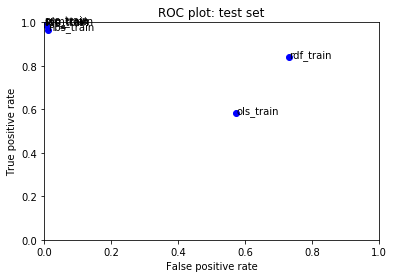

In [21]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [22]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [23]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
73
Al Pacino? Kim Basinger? Tea Leoni? Ryan O'Neal? Richard Schiff? My mouth was watering. I dropped everything to watch this movie on Cable. 30 minutes in I was having trouble staying awake. 60 minutes in and I hit the record button and fell asleep. Finished watching it the next morning. Shouldn't have bothered. What a waste of a great cast and an idea that could have been an interesting story of a \Day in the Life...\" Cure your insomnia if you have it and watch this movie. I guarantee you at least an hour and a half of uninterrupted sleep. Dialogue horrible. Continuity non-existent. Camera work could have been done with a hand held Super 8 and looked better. <br /><br />This movie was a total disaster."
* * * * * * * * * 
77
I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a m

2767
It's not just that this is a bad movie; it's not only that four of the \best\" Mexican movie makers are in this film; and it's not only that the script is terrible. It's just that...this movie sucks...big time. This people are wasting money in terrible scripts. It's supposed to make a criticism about Mexican society but we're fed up with this kind of films. Is bad language supposed to be funny? I don't get it. Mexican cinema is in big trouble if this kind of movies are going to continue playing (and being written and produced).<br /><br />Please, don't think this kind of movies are well received in Mexico: We hate them and they don't reflect us."
* * * * * * * * * 
2794
Claire Denis's movies seem to fall into one of two categories: the violent and bloody or the quiet and intimate. \L'Intrus\" definitely falls into the first category, but it's not so awful as \"Trouble Every Day\" or \"J'ai pas sommeil.\"<br /><br />Now, ever since I saw \"Chocolat,\" I've made it a point to see ev

5794
holy Sh*t this was god awful. i sat in the theater for for an hour and ten minutes and i thought i was going to gouge out my eyes much in the manor Oedipus Rex. dear god. this movie deserves no more credit than anything done by a middle school film buff. please save your money, this movie can offer you nothing. unless you enjoy sideshows and sleeping in movie theaters. you know, h3ll, bring your girlfriend and make things interesting. you will be the only ones there anyway. F@ck this slide show. <br /><br />Ye Be Warned.<br /><br />I recommend not watching this.<br /><br />hello.<br /><br />how are you?<br /><br />I'm pretty good.<br /><br />enjoying this day?<br /><br />I am.<br /><br />this comment was one-hundred times more fun than pretending to watch this daym movie. this is sad.
* * * * * * * * * 
5868
I'm somewhat of a fan of Lynche's work, so I was excited when I found this DVD. Unfortunately, I was very let down. It's a series of short cartoons which attempt to show a dis

8572
This is to the Zatoichi movies as the \Star Trek\" movies were to \"Star Trek\"--except that in this case every one of the originals was more entertaining and interesting than this big, shiny re-do, and also better made, if substance is more important than surface. Had I never seen them, I would have thought this good-looking but empty; since I had, I thought its style inappropriate and its content insufficient. The idea of reviving the character in a bigger, slicker production must have sounded good, but there was no point in it, other than the hope of making money; it's just a show, which mostly fails to capture the atmosphere of the character's world and wholly fails to take the character anywhere he hasn't been already (also, the actor wasn't at his best). I'd been hoping to see Ichi at a late stage of life, in a story that would see him out gracefully and draw some conclusion from his experience overall; this just rehashes bits and pieces from the other movies, seasoned with 

11320
Woody Allen made \September\", proving that even a genius could screw up. This is Mel Brook's \"September\". Monumentally stupid, boring, and unfunny, I must confess I did not watch it through to the end. The flick ranks among the dishonored few (e.g., \"The Money Pit\", \"Out to Sea\", \"Spitfire Grill\") which either put me to sleep or forced me to reach for the \"rewind\" button. And I say this, sadly, as a devoted Mel Brooks fan. He should stick to straight comedy and leave social commentary alone. How the same fellow that made \"Young Frankenstein\" and \"Spaceballs\" could crank out a dog like this is beyond me. To be avoided at all costs."
* * * * * * * * * 
11409
Honestly, who in God's name gave this movie an 8.1 rating?? I guess the people who actually made or starred in the movie were the ones who voted. Otherwise this movie sucks! This movie is nothing more than an amateur, or possibly student, film. I'm a movie fanatic, and have seen terrible movies, but there was lit

14156
Two years before he wrote and directed \Arthur\", Steve Gordon had a minor hit with his screenplay for this crackpot comedic vehicle for Henry Winkler, then TV's \"The Fonz\". A 1950s college thespian (and all-around jerk) woos a co-ed and gets married without any employment prospects on the horizon; to make ends meet, he turns to the flamboyant world of wrestling, eventually becoming a \"Gorgeous George\"-like celebrity. Turning likable Winkler into an obnoxious goof-off probably sounded like an interesting idea at the time (and a sure way to separate him from his television alter-ego), but the jokes and situations are often wrong-headed and mean, staged rather sloppily by director Carl Reiner. Particularly crude is a wincing bit involving Hervé Villechaize (of \"Fantasy Island\") putting the moves on Polly Holliday (Flo from \"Alice\"). As Henry's beloved, Kim Darby looks a little out of her element--particularly when surrounded by all these TV hams--rendering the romance aspec

17244
Wimpy stuffed shirt Armand Louque (blandly played by veteran character actor Dean Jagger in a rare lead role) joins a group of researchers who want to find and destroy the secret technique of creating zombies. Armand falls for the lovely Claire Duval (fetching blonde Dorothy Stone), who uses the meek sap to get Armand's colleague Clifford Grayson (the hopelessly wooden Robert Noland) to marry her. Furious over being used and spurned by Claire, Armand uses his knowledge of voodoo to get revenge. Sound exciting? Well, it sure ain't. For starters, Victor Halperin's static (non)direction lets the meandering and uneventful talk-ridden story plod along at an excruciatingly slow pace. Worse yet, Halperin crucially fails to bring any tension, atmosphere and momentum to the hideously tedious proceedings. The mostly blah acting from a largely insipid cast doesn't help matters any; only George Cleveland as the hearty General Duval and E. Alyn Warren as the irascible Dr. Trevissant manage to

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [24]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1503, 'TN': 981, 'FP': 1561, 'FN': 955, 'Accuracy': 0.4968, 'Precision': 0.49053524804177545, 'Recall': 0.6114727420667209, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [25]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2207, 'TN': 2187, 'FP': 355, 'FN': 251, 'Accuracy': 0.8788, 'Precision': 0.8614363778298204, 'Recall': 0.8978844589096827, 'desc': 'svm_test'}


### MODEL: logistic regression

In [26]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2206, 'TN': 2219, 'FP': 323, 'FN': 252, 'Accuracy': 0.885, 'Precision': 0.8722815342032424, 'Recall': 0.8974776240846216, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [27]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 1866, 'TN': 1904, 'FP': 638, 'FN': 592, 'Accuracy': 0.754, 'Precision': 0.7452076677316294, 'Recall': 0.7591537835638731, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [28]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2060, 'TN': 2096, 'FP': 446, 'FN': 398, 'Accuracy': 0.8312, 'Precision': 0.8220271348762969, 'Recall': 0.8380797396257119, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [29]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2103, 'TN': 2285, 'FP': 257, 'FN': 355, 'Accuracy': 0.8776, 'Precision': 0.8911016949152543, 'Recall': 0.855573637103336, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [30]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2458, 'Neg': 2542, 'TP': 2061, 'TN': 658, 'FP': 1884, 'FN': 397, 'Accuracy': 0.5438, 'Precision': 0.5224334600760456, 'Recall': 0.838486574450773, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

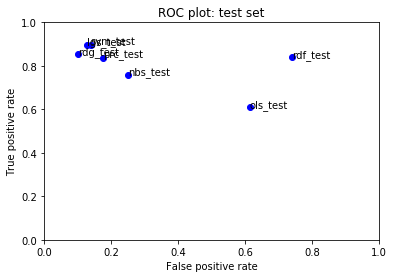

In [31]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [32]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=81, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 2097152)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [33]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.45544


In [34]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [35]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [36]:
my_submission.shape

(25000, 2)

In [37]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation